In [72]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy
from evaluation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Environment

In [45]:
def make_env(depth, cost, ground_truth=False):
    """Returns a MouselabEnv with branching factor 2 and given depth and cost.
    
    If `ground_truth` is True, the reward observed at a given node will be
    constant across runs on this env. This reduces variance of the return."""
    reward = Categorical([0, 1])
    env = MouselabEnv(2, depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth, cost, n=100, ground_truth=None):
    # Note, ground_truth can be an int in which case it acts as a random seed.
    if ground_truth is not None:
        np.random.seed(ground_truth)
        return [make_env(depth, cost, True) for _ in range(n)]
    else:
        return [make_env(depth, cost, False)] * n

# Regression

In [7]:
from toolz import memoize
from exact import sort_tree
   
def regression_data(env):
    """Returns features and Q* for all(*) state-action pairs in an env.
    
    (*) the state space is reduced by treating symmetric states as one.
    """
    Q, V, pi, info = solve(env, hash_state='sort_tree')
    data = []
    def hash_key(args, kwargs):
        s = args[0]
        if s is None:
            return s
        else:
            return sort_tree(env, s)
    @memoize(key=hash_key)
    def rec(s):
        for a in env.actions(s):
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': env.action_features(a, state=s),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)

In [46]:
from sklearn.linear_model import LinearRegression

def run_regression(df):
    X = np.stack(df.features)
    m = LinearRegression().fit(X, df.q_star)
    df['q_hat'] = m.predict(X)
    error = df['q_hat'] - df['q_star']
    df['abs_error'] = np.abs(error)
    df['square_error'] = error ** 2
    return m.coef_, df.square_error.mean()

In [ ]:
features = [
    'cost',
    'myopic_voc',
    'vpi_action',
    'vpi',
    'expected_term_reward',
]
def run_one(depth, cost):
    env = make_env(depth, cost, None)
    df = pd.DataFrame(regression_data(env))
    coef, mse = run_regression(df)
    return [cost, *coef, mse ]

from joblib import Parallel, delayed

depth = 3
jobs = (delayed(run_one)(depth, cost)
        for cost in np.logspace(-3, 0, 8))
rf = pd.DataFrame(Parallel(n_jobs=8)(jobs))

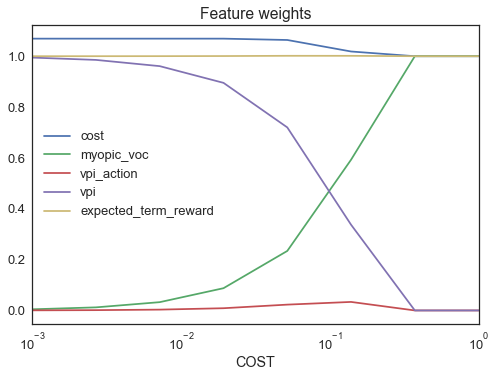

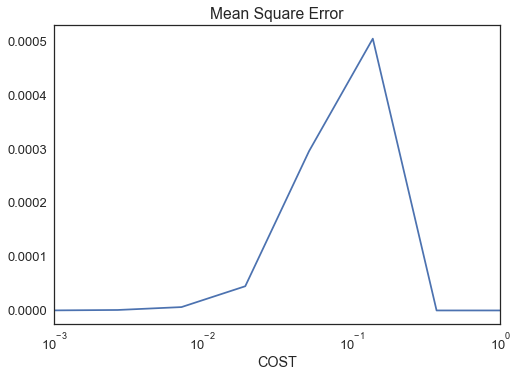

In [54]:
rdf = df
rdf.columns = ['COST', *features, 'MSE']
rdf = rdf.set_index('COST')
rdf.drop('MSE', 1).plot(logx=True, title='Feature weights')
plt.figure()
rdf.MSE.plot(logx=True, title='Mean Square Error')

# plt.plot(coefs[['myopic_voc', 'vpi_action', 'vpi']].sum(axis=1), c='k', ls='--', 
#          label='myopic_voc + vpi_action + vpi')

# Policy learning (via Bayesian Optimization)

In [84]:
def run_params(depth=3, cost=.01):
    print('run_params', cost)
    train_envs = make_envs(depth, cost, n=100, ground_truth=0)
    env = train_envs[0]
    term_action = env.term_action
    policies = {
        'BO': bo_policy(train_envs, n_calls=30),
        # 'BO_unnorm': bo_policy(train_envs, normalize_voi=False, n_calls=30),
        'myopic': LiederPolicy([1, 1, 0, 0, 1]),
        'optimal': optimal_policy(env),
        'full': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    test_envs = make_envs(depth, cost, n=500, ground_truth=None)
    def test():
        print('test', cost)
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['depth'] = depth
            df['cost'] = cost
            yield df
    return pd.concat(test())

data = Parallel(n_jobs=4)(delayed(run_params)(3, cost)
                          for cost in np.logspace(-3, 0, 4))
df = pd.concat(data)

run_params 0.001
run_params 0.01
run_params 0.1
run_params 1.0


/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:340: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BO: [ 5.939  0.384  0.324  0.293  1.   ] -> 1.5 in 19 sec
BO: [ 2.671  0.487  0.     0.513  1.   ] -> 1.995 in 38 sec
BO: [ 4.813  0.327  0.222  0.451  1.   ] -> 2.426 in 49 sec
BO: [ 1.   0.5  0.   0.5  1. ] -> 2.473 in 51 sec
optimal -> 1.5 in 208.4668216588907 sec
'optimal_policy' 208.47 sec
test 1.0
optimal -> 1.9860839843749996 in 206.28014652407728 sec
'optimal_policy' 206.28 sec
test 0.1
optimal -> 2.424765625000001 in 207.4776367219165 sec
'optimal_policy' 207.48 sec
test 0.01
optimal -> 2.4701743164062506 in 206.4898185778875 sec
'optimal_policy' 206.49 sec
test 0.001


(-2, 3)

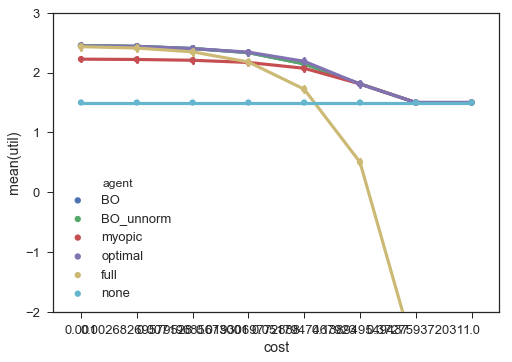

In [78]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df,
              markers='.', size=(4,4), )
plt.ylim(-2, 3)

In [81]:
df.groupby('cost agent'.join()).util.

agent
BO           2.073276
BO_unnorm    2.073276
full        -0.340958
myopic       1.963151
none         1.500000
optimal      2.078589
Name: util, dtype: float64

(-2, 2)

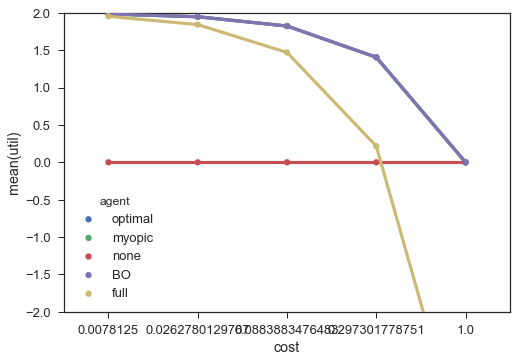

In [18]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df1, markers='.', size=(4,4), )
plt.ylim(-2, 2)

# Scratch